In [1]:
import random
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_sequence():
    sequence = [1, 2]  # Start with 1,2
    count = Counter({i: 0 for i in range(1, 6)})
    count[1], count[2] = 1, 1
    
    # Helper function to get a valid next number avoiding consecutive repeats
    def get_valid_number(choices, last_num):
        valid_choices = [n for n in choices if n != last_num]
        return random.choice(valid_choices) if valid_choices else choices[0]
    
    # 3rd and 4th number (1 or 2 with 0.8 probability)
    for _ in range(2):
        if random.random() < 0.8:
            choices = [n for n in [1, 2] if count[n] < 4]
        else:
            choices = [n for n in [3, 4, 5] if count[n] < 4]
        num = get_valid_number(choices, sequence[-1])
        sequence.append(num)
        count[num] += 1
    
    # Fill 5th to 15th numbers (prioritizing 3 to 5)
    while len(sequence) < 15:
        choices = [n for n in range(3, 6) if count[n] < 4]
        if not choices:
            choices = [n for n in [1, 2] if count[n] < 4]  # If 3-5 are exhausted, use 1 or 2
        num = get_valid_number(choices, sequence[-1])
        sequence.append(num)
        count[num] += 1
    
    # Ensure at least 2 occurrences of either 1 or 2 remain for last 5 numbers
    left_1 = 4 - count[1]
    left_2 = 4 - count[2]
    
    needed_1 = max(0, 2 - left_1)
    needed_2 = max(0, 1 - left_2)
    needed = needed_1 + needed_2
    
    for _ in range(needed):
        replace_idx = random.choice([i for i in range(5, 15) if sequence[i] in [3, 4, 5]])
        removed = sequence[replace_idx]
        count[removed] -= 1
        sequence[replace_idx] = get_valid_number([1, 2], sequence[replace_idx - 1])
        count[sequence[replace_idx]] += 1
    
    # Fill last 5 numbers ensuring exactly 4 appearances of each number
    remaining = [n for n in range(1, 6) for _ in range(4 - count[n])]
    random.shuffle(remaining)
    
    while len(sequence) < 20:
        num = get_valid_number(remaining, sequence[-1])
        sequence.append(num)
        count[num] += 1
        remaining.remove(num)
    
    return sequence

In [3]:
print(generate_sequence())
pd.Series(generate_sequence()).value_counts()

[1, 2, 1, 2, 4, 5, 4, 3, 5, 4, 3, 4, 3, 5, 3, 2, 1, 5, 1, 2]


1    4
2    4
5    4
4    4
3    4
dtype: int64

## attempt on horizontal bar chart

In [49]:
df_all= pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_02/df_all_round_sim.csv')

In [50]:
df_all.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'wicket_type', 'player_dismissed', 'legal_balls_bowled', 'wicket_event',
       'fielder', 'legality', 'bowler_wicket', 'islegal', 'isDotforBatter',
       'isOne', 'isTwo', 'isThree', 'isStrikeRotation', 'isFour', 'isSix',
       'isBowlerWicket', 'is_striker_Out', 'is_nonstriker_Out', 'isWicket',
       'total_runs', 'runs_scored', 'wickets_down', 'run_rate', 'last_fow',
       'partnership_runs', 'isno', 'is_faced_by_batter', 'last_fow_run_rate',
       'fours', 'sixes', 'striker_batting_position',
       'non_striker_batting_position', 'runs_conceeded', 'isDotforbowler',
       'legal_balls_remaining', 'target', 'runs_remaining', 'reqd_run_rate'],
      dtype='object')

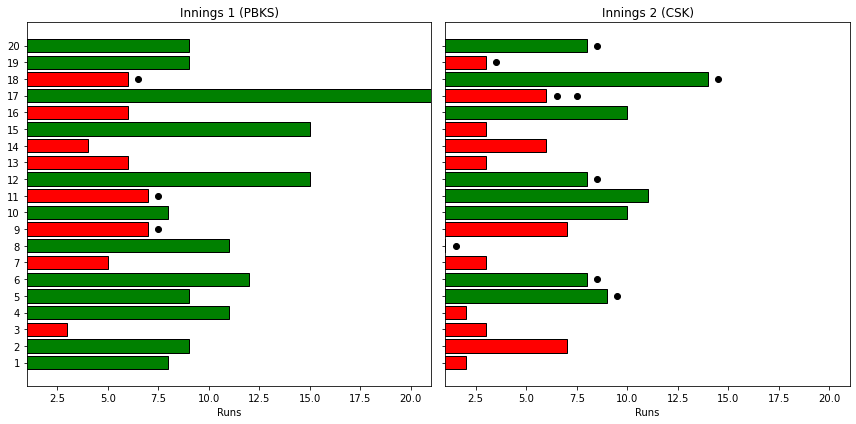

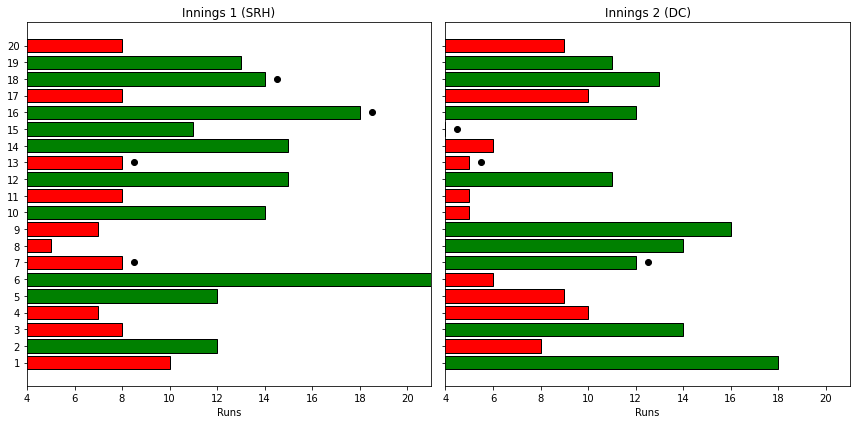

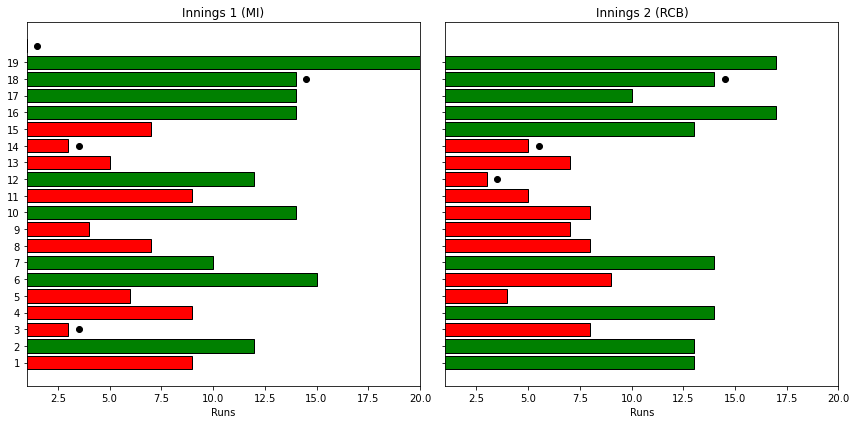

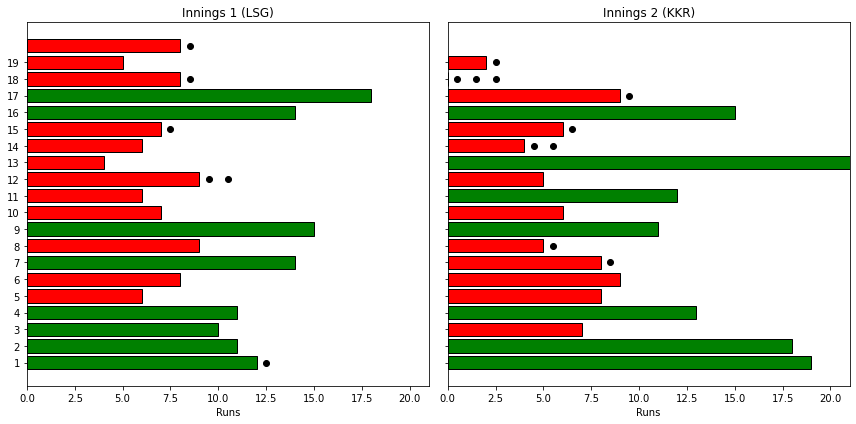

In [58]:
for match, inning in df_all[['match_id', 'innings']].drop_duplicates().itertuples(index=False):
    mask = (df_all['match_id'] == match) & (df_all['innings'] == inning)
    df_all.loc[mask, 'over'] = (
        df_all.loc[mask, 'bowler'] != df_all.loc[mask, 'bowler'].shift()
    ).cumsum()


runs_wkts_overs = df_all.groupby(['match_id','batting_team','innings','over'])\
                    [['total_runs','isWicket','islegal']].sum().reset_index()

    
df_all['over'] = df_all['over'].astype(int)
    

for match in runs_wkts_overs.match_id.unique():

    df = runs_wkts_overs[runs_wkts_overs['match_id']==match]

    overs1 = df[df['innings']==1]['over']
    runs1 = df[df['innings']==1]['total_runs']
    wkts1 = df[df['innings']==1]['isWicket']
    team1 = df[df['innings']==1]['batting_team'].unique()[0]

    rr = 6*df['total_runs'].sum()/df['islegal'].sum()

    overs2 = df[df['innings']==2]['over']
    runs2 = df[df['innings']==2]['total_runs']
    wkts2 = df[df['innings']==2]['isWicket']
    team2 = df[df['innings']==2]['batting_team'].unique()[0]
    
    xmin = min(min(runs1), min(runs2))
    xmax = max(max(runs1), max(runs2))


    # Plotting
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

    def plot_innings(ax, overs, runs, wkts, team_name, threshold=10):
        n = len(overs)
        y_pos = list(range(n))  # [0, 1, 2, ..., n-1]

        # Assign colors to bars based on run threshold
        colors = ['green' if run >= threshold else 'red' for run in runs]

        bars = ax.barh(y_pos, runs, color=colors, edgecolor='black')
        ax.set_title(team_name)
        ax.set_xlabel("Runs")
        
        ax.set_xlim(xmin, xmax)

        ax.set_yticks([int(y) for y in y_pos])

        ax.set_yticklabels([int(y) for y in overs])
        ax.invert_yaxis()  # Top to bottom: 1 to 20

        # Wicket dots stay the same (optional styling)
        for i, (y, wkt_count, run) in enumerate(zip(y_pos, wkts, runs)):
            for j in range(wkt_count):
                ax.plot(run + 0.5 + j, y, 'ko')  # black dot for wicket





    plot_innings(axes[0], overs1, runs1, wkts1, f"Innings 1 ({team1})", threshold=rr)
    plot_innings(axes[1], overs2, runs2, wkts2, f"Innings 2 ({team2})", threshold=rr)


    plt.tight_layout()
    plt.savefig(f'/Users/roumyadas/Desktop/IPL_Simulation/Season_02/plots/run_charts/{match}.jpg', 
            format='jpg', dpi=300, bbox_inches='tight')

    plt.show()

In [34]:
df#.groupby('batting_team')['total_runs'].sum()

,match_id,batting_team,innings,over,total_runs,isWicket
0,S02M001,CSK,2,1,2,0
1,S02M001,CSK,2,2,7,0
2,S02M001,CSK,2,3,3,0
3,S02M001,CSK,2,4,2,0
4,S02M001,CSK,2,5,9,1
5,S02M001,CSK,2,6,8,1
6,S02M001,CSK,2,7,3,0
7,S02M001,CSK,2,8,1,1
8,S02M001,CSK,2,9,7,0
9,S02M001,CSK,2,10,10,0
